## Exploratory Data Analysis of our imputed mushroom dataset
* Run Cramers V to get an indication of dependency of columns with target column
* Make some graphs to get a better idea of dataset



In [1]:
# import packages

import numpy as np
import pandas as pd
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import klib
import plotly.figure_factory as ff
from IPython.core.display import display
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import joblib
# pd.set_option('display.max_columns', None)
# pd.reset_option('max_rows')
#np.set_printoptions(threshold=sys.maxsize)

plt.style.use('dark_background')
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
sns.set(style='ticks', context='talk')

In [2]:
# useful functions
def get_adjusted_cramers_v(contingency_table):
    """ variation of cramers v that adjusts for bias
    via using a smaller mean-squared error.
    It calculates and returns this statistic"""

    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    number_of_obs = np.sum(contingency_table).sum()
    phi2 = chi2 / number_of_obs
    phi2_adjusted = max(0, phi2 - dof/(number_of_obs-1))
    row, column = contingency_table.shape
    row_adjusted = row - ((row-1)**2)/(number_of_obs-1)
    column_adjusted = column - ((column-1)**2)/(number_of_obs-1)
    mini_adjusted = min(row_adjusted, column_adjusted)-1

    cramers_v_adjusted = np.sqrt(phi2_adjusted / mini_adjusted)
    return cramers_v_adjusted


In [3]:
path = r'../../data/processed/mushroom_imputed_2.csv'

mushroom = pd.read_csv(path)
mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,sunken,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,smooth,white,white,white,one,pendant,black,scattered,urban
1,edible,sunken,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,smooth,white,white,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,smooth,white,white,white,one,pendant,brown,numerous,meadows
3,poisonous,sunken,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,smooth,white,white,white,one,pendant,black,scattered,urban
4,edible,sunken,smooth,gray,no,none,free,crowded,broad,black,...,smooth,smooth,white,white,white,one,evanescent,brown,abundant,grasses


In [4]:
mushroom.shape, mushroom.isnull().sum()

((8112, 22),
 class                       0
 cap-shape                   0
 cap-surface                 0
 cap-color                   0
 bruises                     0
 odor                        0
 gill-attachment             0
 gill-spacing                0
 gill-size                   0
 gill-color                  0
 stalk-shape                 0
 stalk-root                  0
 stalk-surface-above-ring    0
 stalk-surface-below-ring    0
 stalk-color-above-ring      0
 stalk-color-below-ring      0
 veil-color                  0
 ring-number                 0
 ring-type                   0
 spore-print-color           0
 population                  0
 habitat                     0
 dtype: int64)

Quick check to see our size; and corrected that we have no missing values at all

Also want to capitalize all columns of the mushroom features

In [5]:
mush_col = mushroom.columns.tolist()
for count, col in enumerate(mush_col):
    mush_col[count] = mush_col[count].title()

mushroom.columns = mush_col
mushroom.columns

Index(['Class', 'Cap-Shape', 'Cap-Surface', 'Cap-Color', 'Bruises', 'Odor',
       'Gill-Attachment', 'Gill-Spacing', 'Gill-Size', 'Gill-Color',
       'Stalk-Shape', 'Stalk-Root', 'Stalk-Surface-Above-Ring',
       'Stalk-Surface-Below-Ring', 'Stalk-Color-Above-Ring',
       'Stalk-Color-Below-Ring', 'Veil-Color', 'Ring-Number', 'Ring-Type',
       'Spore-Print-Color', 'Population', 'Habitat'],
      dtype='object')

In [6]:
# save this adjusted column naming
path_csv = r'../../data/processed/mushroom_imputed_2_adj.csv'
mushroom.to_csv(path_csv)

In [7]:
mush_col = mushroom.drop('Class', axis=1).columns.tolist()

adj_cramers_v_values = []
for col in mush_col:
   contingency_table = pd.crosstab(mushroom['Class'], mushroom[col])
   adj_cramers_v_values.append(get_adjusted_cramers_v(contingency_table))

In [8]:
# get associated strengths for more interpretatbilitty
assoc_strengths = ['Strong', 'Moderate', 'Weak', 'Very weak']

assoc_strengths_values = [assoc_strengths[0] if val > 0.5 else
                          assoc_strengths[1] if val > 0.3 else
                          assoc_strengths[2] if val > 0.1 else
                          assoc_strengths[3] for val in adj_cramers_v_values]

In [9]:
relation_df = pd.DataFrame({'Mushroom Features':mush_col,
                            'Adjusted Cramers V':adj_cramers_v_values,
                            'Association Strength': assoc_strengths_values}).sort_values(by='Adjusted Cramers V', ascending=False)
relation_df.reset_index(drop=True, inplace=True)
relation_df

,Mushroom Features,Adjusted Cramers V,Association Strength
0,Odor,0.970520,Strong
1,Spore-Print-Color,0.753543,Strong
2,Gill-Color,0.680438,Strong
3,Ring-Type,0.602381,Strong
4,Stalk-Surface-Above-Ring,0.589013,Strong
5,Stalk-Surface-Below-Ring,0.575930,Strong
6,Gill-Size,0.539272,Strong
7,Stalk-Color-Above-Ring,0.523683,Strong
8,Stalk-Color-Below-Ring,0.513519,Strong
9,Bruises,0.503003,Strong


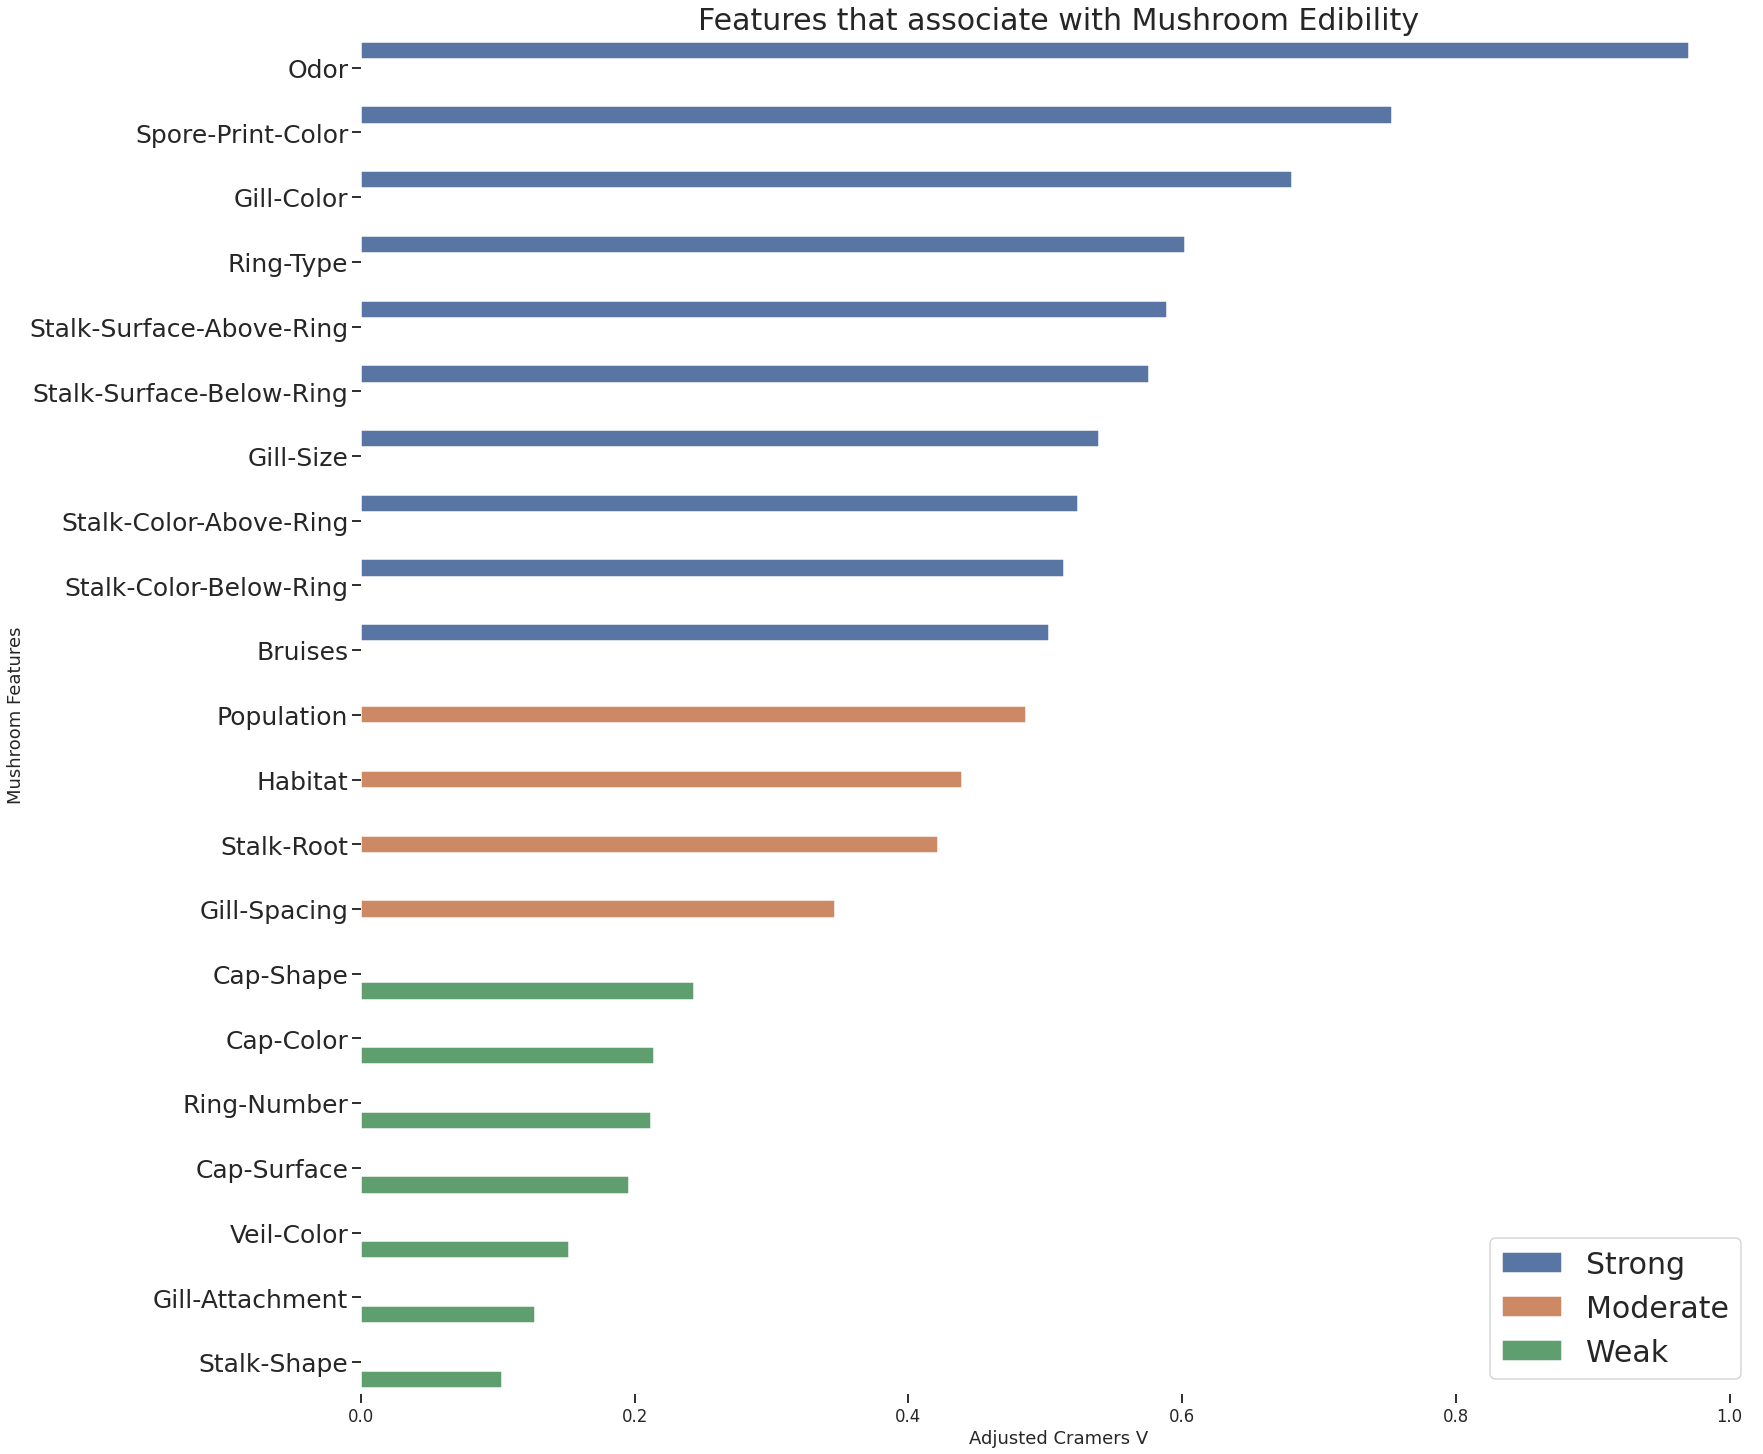

In [10]:
plt.figure(figsize=(25,25))
sns.barplot(data=relation_df, y='Mushroom Features', x='Adjusted Cramers V', hue='Association Strength')
sns.despine(left=True, bottom=True)
plt.title('Features that associate with Mushroom Edibility', fontsize=30)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)

The strongest indicators for edibility of mushroom should be the
odor, spore-print color, gill color, ring type, gill size, bruising, and other stalk-color around the rings

Surprisingly habitat, veil color, cap color, and stalk shape were weak indicators for edibility

In [11]:
# look at the docs and draw more graphs
# also ask more questions about dataset
for col in mush_col:
    print(col, mushroom[col].unique())

Cap-Shape ['sunken' 'bell' 's' 'flat' 'knobbed' 'conical']
Cap-Surface ['smooth' 'scaly' 'fibrous' 'grooves']
Cap-Color ['brown' 'yellow' 'white' 'gray' 'red' 'pink' 'buff' 'cinnamon' 'purple'
 'green']
Bruises ['bruises' 'no']
Odor ['pungent' 'almond' 'anise' 'none' 'foul' 'creosote' 'musty' 'fishy'
 'spicy']
Gill-Attachment ['free' 'attached']
Gill-Spacing ['close' 'crowded']
Gill-Size ['narrow' 'broad']
Gill-Color ['black' 'brown' 'gray' 'pink' 'white' 'chocolate' 'purple' 'green'
 'yellow' 'red' 'buff' 'orange']
Stalk-Shape ['enlarging' 'tapering']
Stalk-Root ['equal' 'club' 'bulbous' 'rooted']
Stalk-Surface-Above-Ring ['smooth' 'fibrous' 'silky' 'scaly']
Stalk-Surface-Below-Ring ['smooth' 'fibrous' 'scaly' 'silky']
Stalk-Color-Above-Ring ['white' 'gray' 'pink' 'brown' 'buff' 'cinnamon' 'yellow' 'red' 'orange']
Stalk-Color-Below-Ring ['white' 'pink' 'gray' 'buff' 'brown' 'cinnamon' 'yellow' 'red' 'orange']
Veil-Color ['white' 'yellow' 'brown' 'orange']
Ring-Number ['one' 'two' 'non